## Libraries

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from tqdm import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Under/Over Sampling
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE

In [2]:
# Models & Metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

In [3]:
# Настройки
# Убираем ограничение отображемых колонок
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

## Data

In [4]:
PATH = "data/"

features_filename = PATH + "Features.csv"
agg_features_filename = PATH + "features_22.csv"
src_features_filename = PATH + "last_price_quant.csv"
lag_features_filename = PATH + "Features_lag.csv"
std_features_filename = PATH + "lag_1_5_mean_std_var.csv"
stocks_features_filename = PATH + "stocks_features.csv"

In [5]:
%%time
features = pd.read_csv(features_filename)

agg_features = pd.read_csv(agg_features_filename)
agg_features = agg_features.drop(columns=['Unnamed: 0', 'IsCorrect'])

src_features = pd.read_csv(src_features_filename)
src_features = src_features.drop(columns=['Unnamed: 0', 'Datetime'])

std_features = pd.read_csv(std_features_filename)
std_features = std_features.drop(columns=['Unnamed: 0', 'IsCorrect'])

stocks_features = pd.read_csv(stocks_features_filename)
stocks_features = stocks_features.drop(columns=['Unnamed: 0'])

CPU times: total: 4.08 s
Wall time: 4.09 s


In [6]:
features = features.merge(agg_features, how='left', on=['LocationId', 'ProductId', 'ValidationDateTime'])
features = features.merge(src_features, how='left', on=['LocationId', 'ProductId', 'ValidationDateTime'])
features = features.merge(std_features, how='left', on=['LocationId', 'ProductId', 'ValidationDateTime'])
features = features.merge(stocks_features, how='left', on=['LocationId', 'ProductId', 'ValidationDateTime'])

In [7]:
# Удаляем вероятности, поскольку решаем задачу "Направление №1"
features = features.drop(columns=['Probability'])
features = features.drop(columns=['Column53', 'Column54', 'Column55', 'Column56'])

# Сортируем данные по времени
features = features.sort_values(by='ValidationDateTime')
features['ValidationDateTime'] = pd.to_datetime(features['ValidationDateTime'])

In [8]:
# Разделяем выборку на тренировочную и обучающую
filter_na_target = features['IsCorrect'].isna()
df_train = features[~filter_na_target]
df_test = features[filter_na_target]

# Приводим таргет к целочисленному типу
df_train['IsCorrect'] = df_train['IsCorrect'].astype(np.uint8)

# Разбиваем данные на обучающие и валидацию для чек-поинта
train_checkpoint = df_train.query('ValidationDateTime >= "2023-07-15"')

In [9]:
df_train = df_train.query("(ValidationDateTime >= '2023-07-09') & (ValidationDateTime < '2023-07-15')")
df_train = pd.concat([df_train, train_checkpoint])

In [10]:
# Смотрим сколько признаков имеют NaN для большинства объектов
# Отдельно по классам и если для обоих классов эти признаки не значимы, тогда удаляем признаки
threshold_drop = 0.9
nan_df_cls1 = df_train[df_train["IsCorrect"] == 1].isna().sum()
nan_df_cls0 = df_train[df_train["IsCorrect"] == 0].isna().sum()
count_cls1 = len(df_train[df_train["IsCorrect"] == 1] )
count_cls0 = len(df_train[df_train["IsCorrect"] == 0] )
drop_col_cls1 =  nan_df_cls1[nan_df_cls1 > count_cls1*threshold_drop]
drop_col_cls0 =  nan_df_cls0[nan_df_cls0 > count_cls0*threshold_drop]
drop_columns = set(drop_col_cls1.index) & set(drop_col_cls0.index)

# Исключаем признаки с большим кол-ом пропусков
df_train = df_train.drop(columns=drop_columns, errors='ignore')
df_train.shape

(46209, 102)

In [11]:
train_loc_id = set(df_train['LocationId'].unique())
test_loc_id = set(df_test['LocationId'].unique())
df_train = df_train[df_train['LocationId'].apply(lambda x: x in test_loc_id)]

In [12]:
train_prod_id = set(df_train['ProductId'].unique())
test_prod_id = set(df_test['ProductId'].unique())
df_train = df_train[df_train['ProductId'].apply(lambda x: x in test_prod_id)]

In [13]:
target_column = 'IsCorrect'
report_date_column = 'ValidationDateTime'
id_client_columns = ["LocationId", "ProductId"]
feature_columns = list(set(df_train.columns) - set([report_date_column]) - set([target_column]) - set(id_client_columns))

In [14]:
# Поиск константных признаков
constant_features = []
# Если везде одно значение  - это константа
for column in feature_columns:
    if len(df_train[column].value_counts()) == 1:
        constant_features.append(column)
df_train = df_train.drop(columns=constant_features, errors='ignore')
feature_columns = list(set(feature_columns) - set(constant_features))
df_train.shape

(44163, 93)

## Train and Test Data

In [15]:
X_train = df_train[feature_columns]
y_train = df_train[target_column]

X_val = df_test[feature_columns]
# y_val = df_train[target_column]

In [16]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

In [17]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [18]:
def metrics_classifie(y_test, X_test, y_pred,model, name='model'):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name} - Precision: {precision:.2f} | Recall: {recall:.2} | F1-score: {f1:.2} | ROCAUC: {roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])}')


In [19]:
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.9331262677484787, 1: 1.077198887750622}

## Model

In [20]:
model = CatBoostClassifier(
    iterations=200,
    max_depth=4,
    l2_leaf_reg=7,
    colsample_bylevel=0.098,
    subsample=0.71,
    min_data_in_leaf=243,
    max_bin=150,
    random_strength=1,
    eval_metric="AUC",
    early_stopping_rounds=100, 
    class_weights=class_weights, 
    random_state=53
)
model.fit(X_train, y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

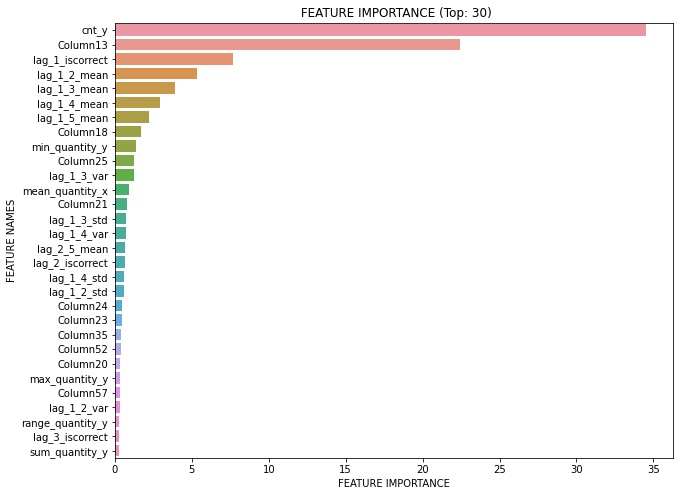

In [21]:
# Построение важности признаков
dfi = plot_feature_importance(model.get_feature_importance(), X_val.columns, top_n=30)

## Making Submit

In [22]:
y_pred_proba = model.predict_proba(X_val)[:, 1]

In [23]:
submit = df_test[['LocationId', 'ProductId', 'ValidationDateTime']]
submit['CalculatedProbability'] = y_pred_proba

In [24]:
submit.to_csv("GibData_3.csv", index=False, sep=';')